# We're going to put a prior on height

We know empirically that the amplitudes of the seismic mode envelope roughly takes the shape of a Gaussian function. I say 'roughly', because departures from this are possible (much how glitches can cause departers from the curved asymptotic relation for mode frequencies previously). We will use the same method to account for noise in the mode amplitudes.

If we define a Gaussian function, centered at $\nu_{\rm max}$ with a width $w$ and an amplitude $A$ as

$\mathcal{G}(n, \nu_{\rm max}, w, A)$,

we can say that the amplitudes of our radial modes follow the following distribution:

$A_{n, l=0} = \mathcal{G}(n, \nu_{\rm max}, w, A) + \mathcal{N}(0, \sigma_{A})$,

where $\sigma_A$ is the noise on the amplitudes.

In general, we can describe the $A_{n, l=1,2}$ amplitude heights as a function of the radial mode amplitude height. We're going to assume that all modes amplitudes are subject to the same noise level $\sigma_{A}$, but are some fraction $V_{1, 2}$ of the radial mode amplitude. Using the nomenclature from Lund et al. (2017). Ignoring the splitting of modes due to rotation, we can describe the height of a mode as:

$H_{nl} = V_{l}^2 \mathcal{S}_{n,0} = V_{l}^2 \frac{2A_{nl}^2}{\pi\Gamma_{nl}} = \frac{2}{\pi\Gamma_{nl}} \times (V_{l} A_{nl})^2$ ,

where $\Gamma$ is the linewidth. We already perform the transformation from amplitude to height in our model as it stands. So instead of using $V_{l}^2$ to modulate $\mathcal{S}$, we'll use $V_{l}$ to directly modulate $A_{nl}$.

$A_{n, l=1} = V_{1} \mathcal{G}(n, \nu_{\rm max}, w, A) + \mathcal{N}(0, \sigma_{A})$,

$A_{n, l=2} = V_{2} \mathcal{G}(n, \nu_{\rm max}, w, A) + \mathcal{N}(0, \sigma_{A})$,

We'll set up some sensible priors for this. Something like:

$\nu_{\rm max} \sim \mathcal{N}(\nu_{\rm max, \rm prior}, 100.)$

$w \sim \mathcal{N}(0.1\times\nu_{\rm max, prior}, 10.)$

$A \sim \mathcal{N}(0.8\times p_{\rm max}, 10)$

$V_1 \sim \mathcal{N}(1.2, .5)$

$V_2 \sim \mathcal{N}(0.7, .5)$

$\sigma_{A} \sim \gamma(\alpha=1., beta=0.5)$

where we've taken the mean values for $V_{1, 2}$ from what we roughly expect them to be for the *Kepler* mission from the LEGACY data, and $p_{\rm max}$ is the maximum power value in the data we're fitting to. If we're having trouble with these values we can do a proper fit for them from the literature amplitudes, but I expect we'll be okay.

Note: The $\nu_{\rm max}$ here doubles as an entry in the asympotic mode frequency model.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns
import mystyle as ms

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

import pymc3 as pm
import arviz

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Build the model

In [21]:
class model():
    def __init__(self, f, n0_, n1_, n2_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        
    def epsilon(self, i, theano=True):
        eps = tt.zeros((3,3))
        eps0 = tt.set_subtensor(eps[0][0], 1.)
        eps1 = tt.set_subtensor(eps[1][0], tt.cos(i)**2)
        eps1 = tt.set_subtensor(eps1[1], 0.5 * tt.sin(i)**2)
        eps2 = tt.set_subtensor(eps[2][0], 0.25 * (3. * tt.cos(i)**2 - 1.)**2)
        eps2 = tt.set_subtensor(eps2[1], (3./8.)*tt.sin(2*i)**2)
        eps2 = tt.set_subtensor(eps2[2], (3./8.) * tt.sin(i)**4)

        eps = tt.set_subtensor(eps[0], eps0)
        eps = tt.set_subtensor(eps[1], eps1)
        eps = tt.set_subtensor(eps[2], eps2)
        
        if not theano:
            return eps.eval()
        return eps
            

    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, eps, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * eps[l,abs(m)], 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b = p
               
        # Calculate the modes
        eps = self.epsilon(i, theano)        
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, eps)
        self.mode(1, f1, h1, g1, eps, split)
        self.mode(2, f2, h2, g2, eps, split)
               
        #Create the model
        self.mod = self.modes + b
        return self.mod

    # Small separations are fractional
    def asymptotic(self, n, numax, deltanu, alpha, epsilon, d=0.): 
        nmax = (numax / deltanu) - epsilon
        curve = (alpha/2.)*(n-nmax)*(n-nmax)
        return (n + epsilon + d + curve) * deltanu

    def f0(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n0, numax, deltanu, alpha, epsilon, 0.)
    
    def f1(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n1, numax, deltanu, alpha, epsilon, d01)
    
    def f2(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n2+1, numax, deltanu, alpha, epsilon, -d02)

    def gaussian(self, freq, numax, w, A):
        return A * tt.exp(-0.5 * (freq - numax)**2 / w**2)

    def A0(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)
        if theano:
            return height
        else:
            return height.eval()
    
    def A1(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)*V1        
        if theano:
            return height
        else:
            return height.eval()
    
    def A2(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)*V2      
        if theano:
            return height
        else:
            return height.eval()

In [22]:
nmodes = 4
nbase = 16
n0_ = np.arange(nmodes)+nbase
n1_ = np.copy(n0_)
n2_ = np.copy(n0_) - 1.
fs = .05
nyq = (0.5 * (1./58.6) * u.hertz).to(u.microhertz).value
ff = np.arange(fs, nyq, fs)

In [23]:
deltanu_  =  60.
numax_= 1150.
alpha_ = 0.01
epsilon_ = 1.1
d01_ = deltanu_/2. / deltanu_
d02_ = 6. / deltanu_

In [24]:
mod = model(ff, n0_, n1_, n2_)

In [25]:
init_f = [numax_, deltanu_, alpha_, epsilon_, d01_, d02_]

f0_true = mod.f0(init_f)
f1_true = mod.f1(init_f)
f2_true = mod.f2(init_f)

sigma0_ = 1.5
sigma1_ = 2.0
sigma2_ = .5
f0_ = mod.f0(init_f) + np.random.randn(len(f0_true)) * sigma0_
f1_ = mod.f1(init_f) + np.random.randn(len(f1_true)) * sigma1_
f2_ = mod.f2(init_f) + np.random.randn(len(f2_true)) * sigma2_

In [26]:
lo = f2_.min() - .25*deltanu_
hi = f1_.max() + .25*deltanu_

sel = (ff > lo) & (ff < hi)
f = ff[sel]

And now lets reset the model for the new frequency range...

In [27]:
mod = model(f, n0_, n1_, n2_)

In [28]:
w_ = (0.25 * numax_)/2.355
V1_ = 1.2
V2_ = 0.7
A_ = 10.
init_h =[numax_,   #numax
         w_,       #envelope width
         A_,       #envelope amplitude
         V1_,      #dipole visibility
         V2_       #ocotopole visibility
        ]
amps = [mod.A0(f0_, init_h, theano=False),
        mod.A1(f1_, init_h, theano=False),
        mod.A2(f2_, init_h, theano=False)]
widths = [np.ones(len(f0_)) * 2.0,
          np.ones(len(f0_)) * 2.0,
          np.ones(len(f0_)) * 2.0,]

In [29]:
split_ = 1.
incl_ = np.pi/4.
init_m =[f0_,                         # l0 modes
       f1_,                         # l1 modes
       f2_,                         # l2 modes
       widths[0],             # l0 widths
       widths[1],             # l1 widths
       widths[2],             # l2 widths
       amps[0]**2 * 2.0 / np.pi / widths[0] ,# l0 heights
       amps[1]**2 * 2.0 / np.pi / widths[1] ,# l1 heights
       amps[2]**2 * 2.0 / np.pi / widths[2] ,# l2 heights
       split_,       # splitting
       incl_,                    # inclination angle
       1.                           # background parameters
        ]
p = mod.model(init_m, theano=False)*np.random.chisquare(2., size=len(f))/2

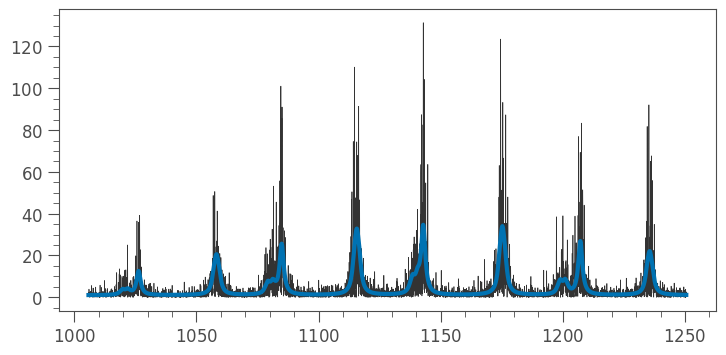

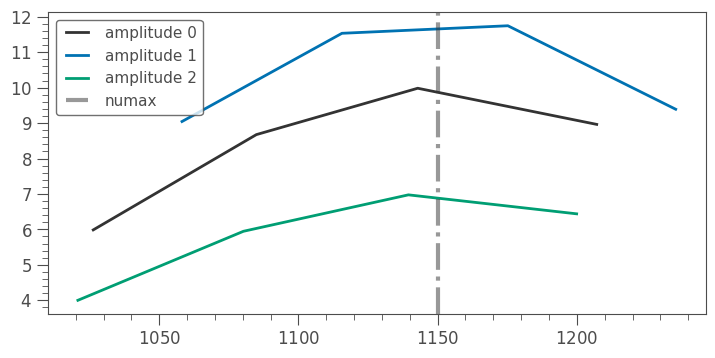

In [30]:
with plt.style.context(ms.ms):
    plt.plot(f, p)
    plt.plot(f, mod.model(init_m, theano=False), lw=3)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot(f0_, amps[0], label='amplitude 0', lw=2)
    ax.plot(f1_, amps[1], label='amplitude 1', lw=2)
    ax.plot(f2_, amps[2], label='amplitude 2', lw=2)
    ax.axvline(numax_, lw=3, ls='-.', label='numax', alpha=.5)
    ax.legend()
    plt.show()    

## First lets fit the mode heights...

In [39]:
pm_model = pm.Model()

with pm_model:   
    numax = pm.Normal('numax', numax_, 1., testval=numax_)
    w = pm.Normal('w', w_, 1., testval=w_)
    A = pm.Normal('A', A_, 10., testval=A_)
    V1 = pm.Normal('V1', V1_, 0.1, testval=V1_)
    V2 = pm.Normal('V2', V2_, 0.1, testval=V2_)
    
    a0 = pm.Normal('a0', mod.A0(f0_, [numax, w, A, V1, V2]), 1., shape=len(f0_)) 
    a1 = pm.Normal('a1', mod.A1(f1_, [numax, w, A, V1, V2]), 1., shape=len(f1_)) 
    a2 = pm.Normal('a2', mod.A2(f2_, [numax, w, A, V1, V2]), 1., shape=len(f2_)) 
    
    pm.Normal('like0', a0, .1, observed=amps[0])
    pm.Normal('like1', a1, .1, observed=amps[1])
    pm.Normal('like2', a2, .1, observed=amps[2])    
    
    trace = pm.sample(tune=1000,chains=4)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [a2, a1, a0, V2, V1, A, w, numax]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1043.67draws/s]


In [40]:
pm.summary(trace)

mean        sd  mc_error      hpd_2.5     hpd_97.5        n_eff  \
numax  1150.003205  1.001565  0.015457  1147.910658  1151.865573  4488.712664   
w       122.085549  1.049681  0.015803   120.035749   124.132416  4293.733697   
A         9.989208  0.484207  0.009980     9.026319    10.930705  2766.869046   
V1        1.199843  0.067562  0.001353     1.070532     1.333317  2406.949804   
V2        0.702363  0.058345  0.001075     0.584342     0.809367  3283.198090   
a0__0     5.983740  0.099897  0.001300     5.786595     6.171152  5565.064792   
a0__1     8.674699  0.095790  0.001285     8.489034     8.860127  5793.736930   
a0__2     9.980399  0.101072  0.001405     9.786055    10.180538  5524.322804   
a0__3     8.963153  0.099698  0.001390     8.749698     9.151950  4964.224068   
a1__0     9.042581  0.096808  0.001325     8.862942     9.235693  5414.756019   
a1__1    11.534812  0.094583  0.001412    11.331471    11.705284  4790.034032   
a1__2    11.746057  0.098120  0.001474    11.555196    11.929700  4067.267685   
a1__3     9.390736  0.100022  0.001245     9.197953     9.581090  5218.444557   
a2__0     3.997715  0.103576  0.001530     3.796138     4.199677  4816.737830   
a2__1     5.945342  0.100388  0.001405     5.759364     6.153550  5443.774320   
a2__2     6.973887  0.105178  0.001694     6.773586     7.164637  4655.750542   
a2__3     6.441225  0.099499  0.001531     6.258951     6.643209  4449.891892   

           Rhat  
numax  0.999305  
w      0.999479  
A      0.999682  
V1     1.000870  
V2     0.999198  
a0__0  0.999047  
a0__1  0.999344  
a0__2  0.999377  
a0__3  0.999073  
a1__0  0.999361  
a1__1  0.999425  
a1__2  0.999130  
a1__3  0.999253  
a2__0  1.000248  
a2__1  0.999067  
a2__2  0.999675  
a2__3  1.000294

In [41]:
    ax.plot(f0_, amps[0], label='amplitude 0', lw=2)
    ax.plot(f1_, amps[1], label='amplitude 1', lw=2)
    ax.plot(f2_, amps[2], label='amplitude 2', lw=2)
    ax.axvline(numax_, lw=3, ls='-.', label='numax', alpha=.5)

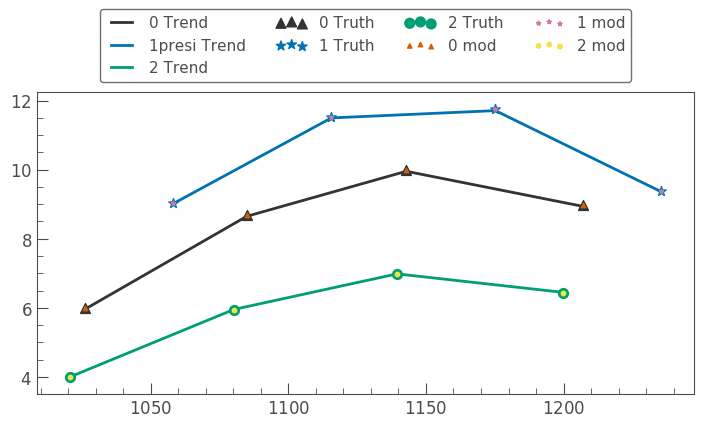

In [42]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax', 'w', 'A', 'V1','V2']]
    resls = [np.median(trace[label],axis=0) for label in ['a0','a1','a2']]
       
    ax.plot(f0_, mod.A0(f0_, res,theano=False), label='0 Trend',lw=2, zorder=1)
    ax.plot(f1_, mod.A1(f1_, res,theano=False), label='1presi Trend',lw=2, zorder=1)
    ax.plot(f2_, mod.A2(f2_, res,theano=False), label='2 Trend',lw=2, zorder=1)

    ax.scatter(f0_, amps[0], marker='^',label='0 Truth',  s=50, zorder=2)
    ax.scatter(f1_, amps[1], marker='*',label='1 Truth',  s=50, zorder=2)
    ax.scatter(f2_, amps[2], marker='o',label='2 Truth',  s=50, zorder=2)   

    ax.scatter(f0_, resls[0], marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(f1_, resls[1], marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(f2_, resls[2], marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))    

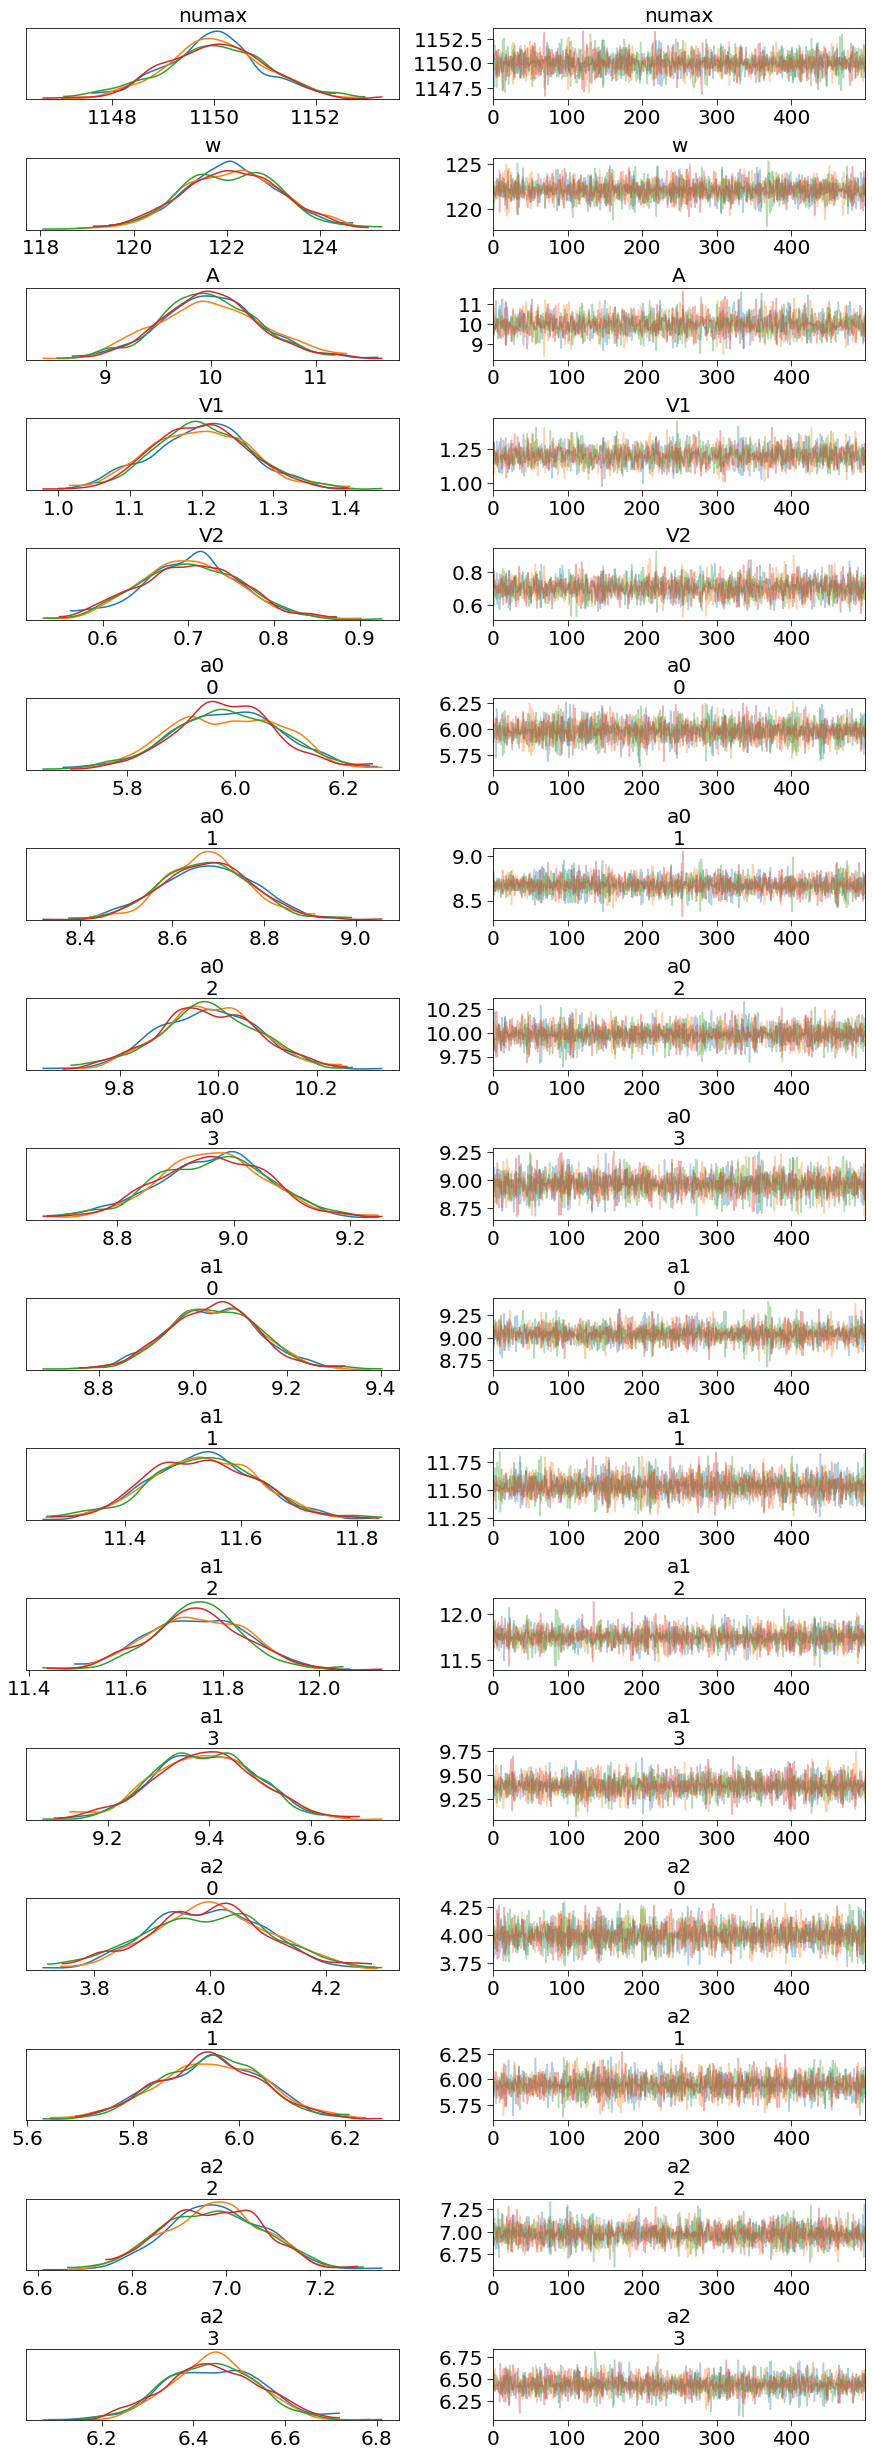

In [43]:
pm.traceplot(trace);

Works well and seemingly at a tiny expense. Let's try and put this into the real thing.

# Now lets try and fit this

In [44]:
pm_model = pm.Model()

BNormal = pm.Bound(pm.Normal, lower=0.)

with pm_model:   
    numax = pm.Normal('numax', numax_, 1., testval=numax_)
    deltanu = pm.Normal('deltanu', deltanu_, 1., testval=deltanu_)
    alpha = pm.Normal('alpha', alpha_, 0.001, testval=alpha_)
    epsilon = pm.Normal('epsilon', epsilon_, 1., testval=epsilon_)
    d01     = pm.Normal('d01', d01_, 0.01, testval=d01_)   
    d02     = pm.Normal('d02', d02_, 0.01, testval=d02_)
    
    sigma0 = pm.HalfNormal('sigma0', 1., testval=1.5)
    sigma1 = pm.HalfNormal('sigma1', 1., testval=2.)
    sigma2 = pm.HalfNormal('sigma2', 1., testval=.5)

    f0 = pm.Normal('f0', mod.f0([numax, deltanu, alpha, epsilon, d01, d02]), sigma0, shape=len(f0_))
    f1 = pm.Normal('f1', mod.f1([numax, deltanu, alpha, epsilon, d01, d02]), sigma1, shape=len(f0_))
    f2 = pm.Normal('f2', mod.f2([numax, deltanu, alpha, epsilon, d01, d02]), sigma2, shape=len(f0_))

    g0 = pm.HalfNormal('g0', sigma=2.0, testval=init_m[3], shape=len(init_m[3]))
    g1 = pm.HalfNormal('g1', sigma=2.0, testval=init_m[4], shape=len(init_m[4]))
    g2 = pm.HalfNormal('g2', sigma=2.0, testval=init_m[5], shape=len(init_m[5]))

    w = pm.Normal('w', w_, 1., testval=w_)
    A = pm.Normal('A', A_, 1., testval=A_)
    V1 = pm.Normal('V1', V1_, 0.1, testval=V1_)
    V2 = pm.Normal('V2', V2_, 0.1, testval=V2_)
    
    a0 = pm.Normal('a0', mod.A0(f0_, [numax, w, A, V1, V2]), 1., shape=len(f0_)) 
    a1 = pm.Normal('a1', mod.A1(f1_, [numax, w, A, V1, V2]), 1., shape=len(f1_)) 
    a2 = pm.Normal('a2', mod.A2(f2_, [numax, w, A, V1, V2]), 1., shape=len(f2_))     
    
    h0 = pm.Deterministic('h0', 2*a0*a0/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*a1*a1/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*a2*a2/np.pi/g2)
    
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init_m[9] * np.sin(init_m[10]))
    cosi = pm.Uniform('cosi', 0., 1., testval=np.cos(init_m[10]))
    
    i = pm.Deterministic('i', tt.arccos(cosi))
    split = pm.Deterministic('split', xsplit/tt.sin(i))
    
    b = BNormal('b', mu=1., sigma=.1, testval=1.)
    
    fit = mod.model([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b])
    
    like = pm.Gamma('like', alpha=1., beta=1./fit, observed=p)

In [45]:
with pm_model:
    trace = pm.sample(tune=1000, chains=4)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [b, cosi, xsplit, a2, a1, a0, V2, V1, A, w, g2, g1, g0, f2, f1, f0, sigma2, sigma1, sigma0, d02, d01, epsilon, alpha, deltanu, numax]
Sampling 4 chains: 100%|██████████| 6000/6000 [34:28<00:00,  1.64draws/s]  
ERROR:pymc3:There were 212 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 346 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [46]:
pm.summary(trace)

mean        sd  mc_error      hpd_2.5     hpd_97.5  \
numax    1149.801618  1.105533  0.071132  1147.199404  1151.562465   
deltanu    59.917428  0.213696  0.009880    59.570333    60.398156   
alpha       0.010185  0.000938  0.000041     0.008211     0.011939   
epsilon     1.112737  0.067764  0.003192     0.969993     1.232105   
d01         0.504699  0.006829  0.000284     0.489727     0.516739   
d02         0.097403  0.006379  0.000194     0.084366     0.110065   
f0__0    1026.289779  0.173865  0.009653  1025.967730  1026.609120   
f0__1    1084.757145  0.129639  0.003859  1084.506627  1085.040916   
f0__2    1142.890943  0.166842  0.008415  1142.580168  1143.218388   
f0__3    1207.106907  0.136910  0.005145  1206.854125  1207.406765   
f1__0    1058.000928  0.137576  0.004379  1057.696588  1058.273128   
f1__1    1115.359257  0.122309  0.004911  1115.078013  1115.584920   
f1__2    1175.255042  0.116715  0.003850  1175.008541  1175.489707   
f1__3    1235.349808  0.158103  0.010655  1235.084267  1235.611800   
f2__0    1020.464767  0.420776  0.031842  1019.757085  1021.357800   
f2__1    1079.983017  0.256583  0.014434  1079.466085  1080.416272   
f2__2    1139.632054  0.480946  0.025807  1138.804899  1140.608093   
f2__3    1199.492731  0.224467  0.011957  1199.015110  1199.847242   
w         121.909078  0.941923  0.043957   119.963424   123.810169   
A          10.033031  0.460613  0.023325     9.202252    10.884647   
V1          1.160041  0.059650  0.001994     1.029504     1.275712   
V2          0.702318  0.071940  0.004685     0.595580     0.838350   
a0__0       5.647557  0.366228  0.018769     5.000460     6.378700   
a0__1       9.289471  0.436156  0.016124     8.469781    10.233267   
a0__2       9.772830  0.648243  0.038346     8.508656    10.884285   
a0__3       9.382707  0.501706  0.033447     8.552225    10.305616   
a1__0       8.088161  0.339259  0.015677     7.537888     8.846614   
a1__1      11.176056  0.452348  0.026497    10.216787    11.955875   
a1__2      11.475232  0.506858  0.034866    10.633990    12.343221   
a1__3       8.862959  0.373158  0.019067     8.284481     9.616241   
...              ...       ...       ...          ...          ...   
sigma2      0.548526  0.333814  0.018957     0.212999     1.243587   
g0__0       1.941417  0.398896  0.016694     1.210090     2.858278   
g0__1       1.925406  0.303126  0.015713     1.343743     2.455901   
g0__2       1.902984  0.398808  0.026386     1.140830     2.480581   
g0__3       2.382643  0.308653  0.012881     1.691745     2.890763   
g1__0       2.109409  0.305936  0.018468     1.555624     2.604012   
g1__1       2.078599  0.247290  0.010756     1.633452     2.596644   
g1__2       2.109987  0.231453  0.009057     1.663761     2.581489   
g1__3       1.849595  0.287952  0.016172     1.274093     2.354961   
g2__0       2.344451  0.740118  0.030461     0.948143     3.778758   
g2__1       1.221290  0.376634  0.017738     0.517980     1.919275   
g2__2       2.497432  0.730067  0.046710     1.342764     3.831625   
g2__3       2.111647  0.480380  0.026023     1.100669     2.897878   
h0__0      10.905393  2.586724  0.100946     6.320102    16.446690   
h0__1      29.408681  6.038591  0.280141    19.508181    42.303885   
h0__2      33.372321  7.650286  0.347189    19.967476    47.279642   
h0__3      24.163168  5.150119  0.294927    17.139474    34.571874   
h1__0      20.319021  4.162857  0.235447    14.542773    28.934400   
h1__1      38.949676  6.288524  0.259460    27.356127    52.192198   
h1__2      40.358035  6.248846  0.252388    29.767628    54.244559   
h1__3      27.907545  5.896949  0.338339    19.330619    39.458962   
h2__0       6.022164  2.141546  0.104977     3.052966    10.432261   
h2__1      21.025580  7.057519  0.382614    11.269247    34.929003   
h2__2      13.086355  3.888366  0.234636     6.134739    19.027701   
h2__3      14.053278  3.694168  0.173302     8.688248    21.607371   
xsplit      0.767310  0.05

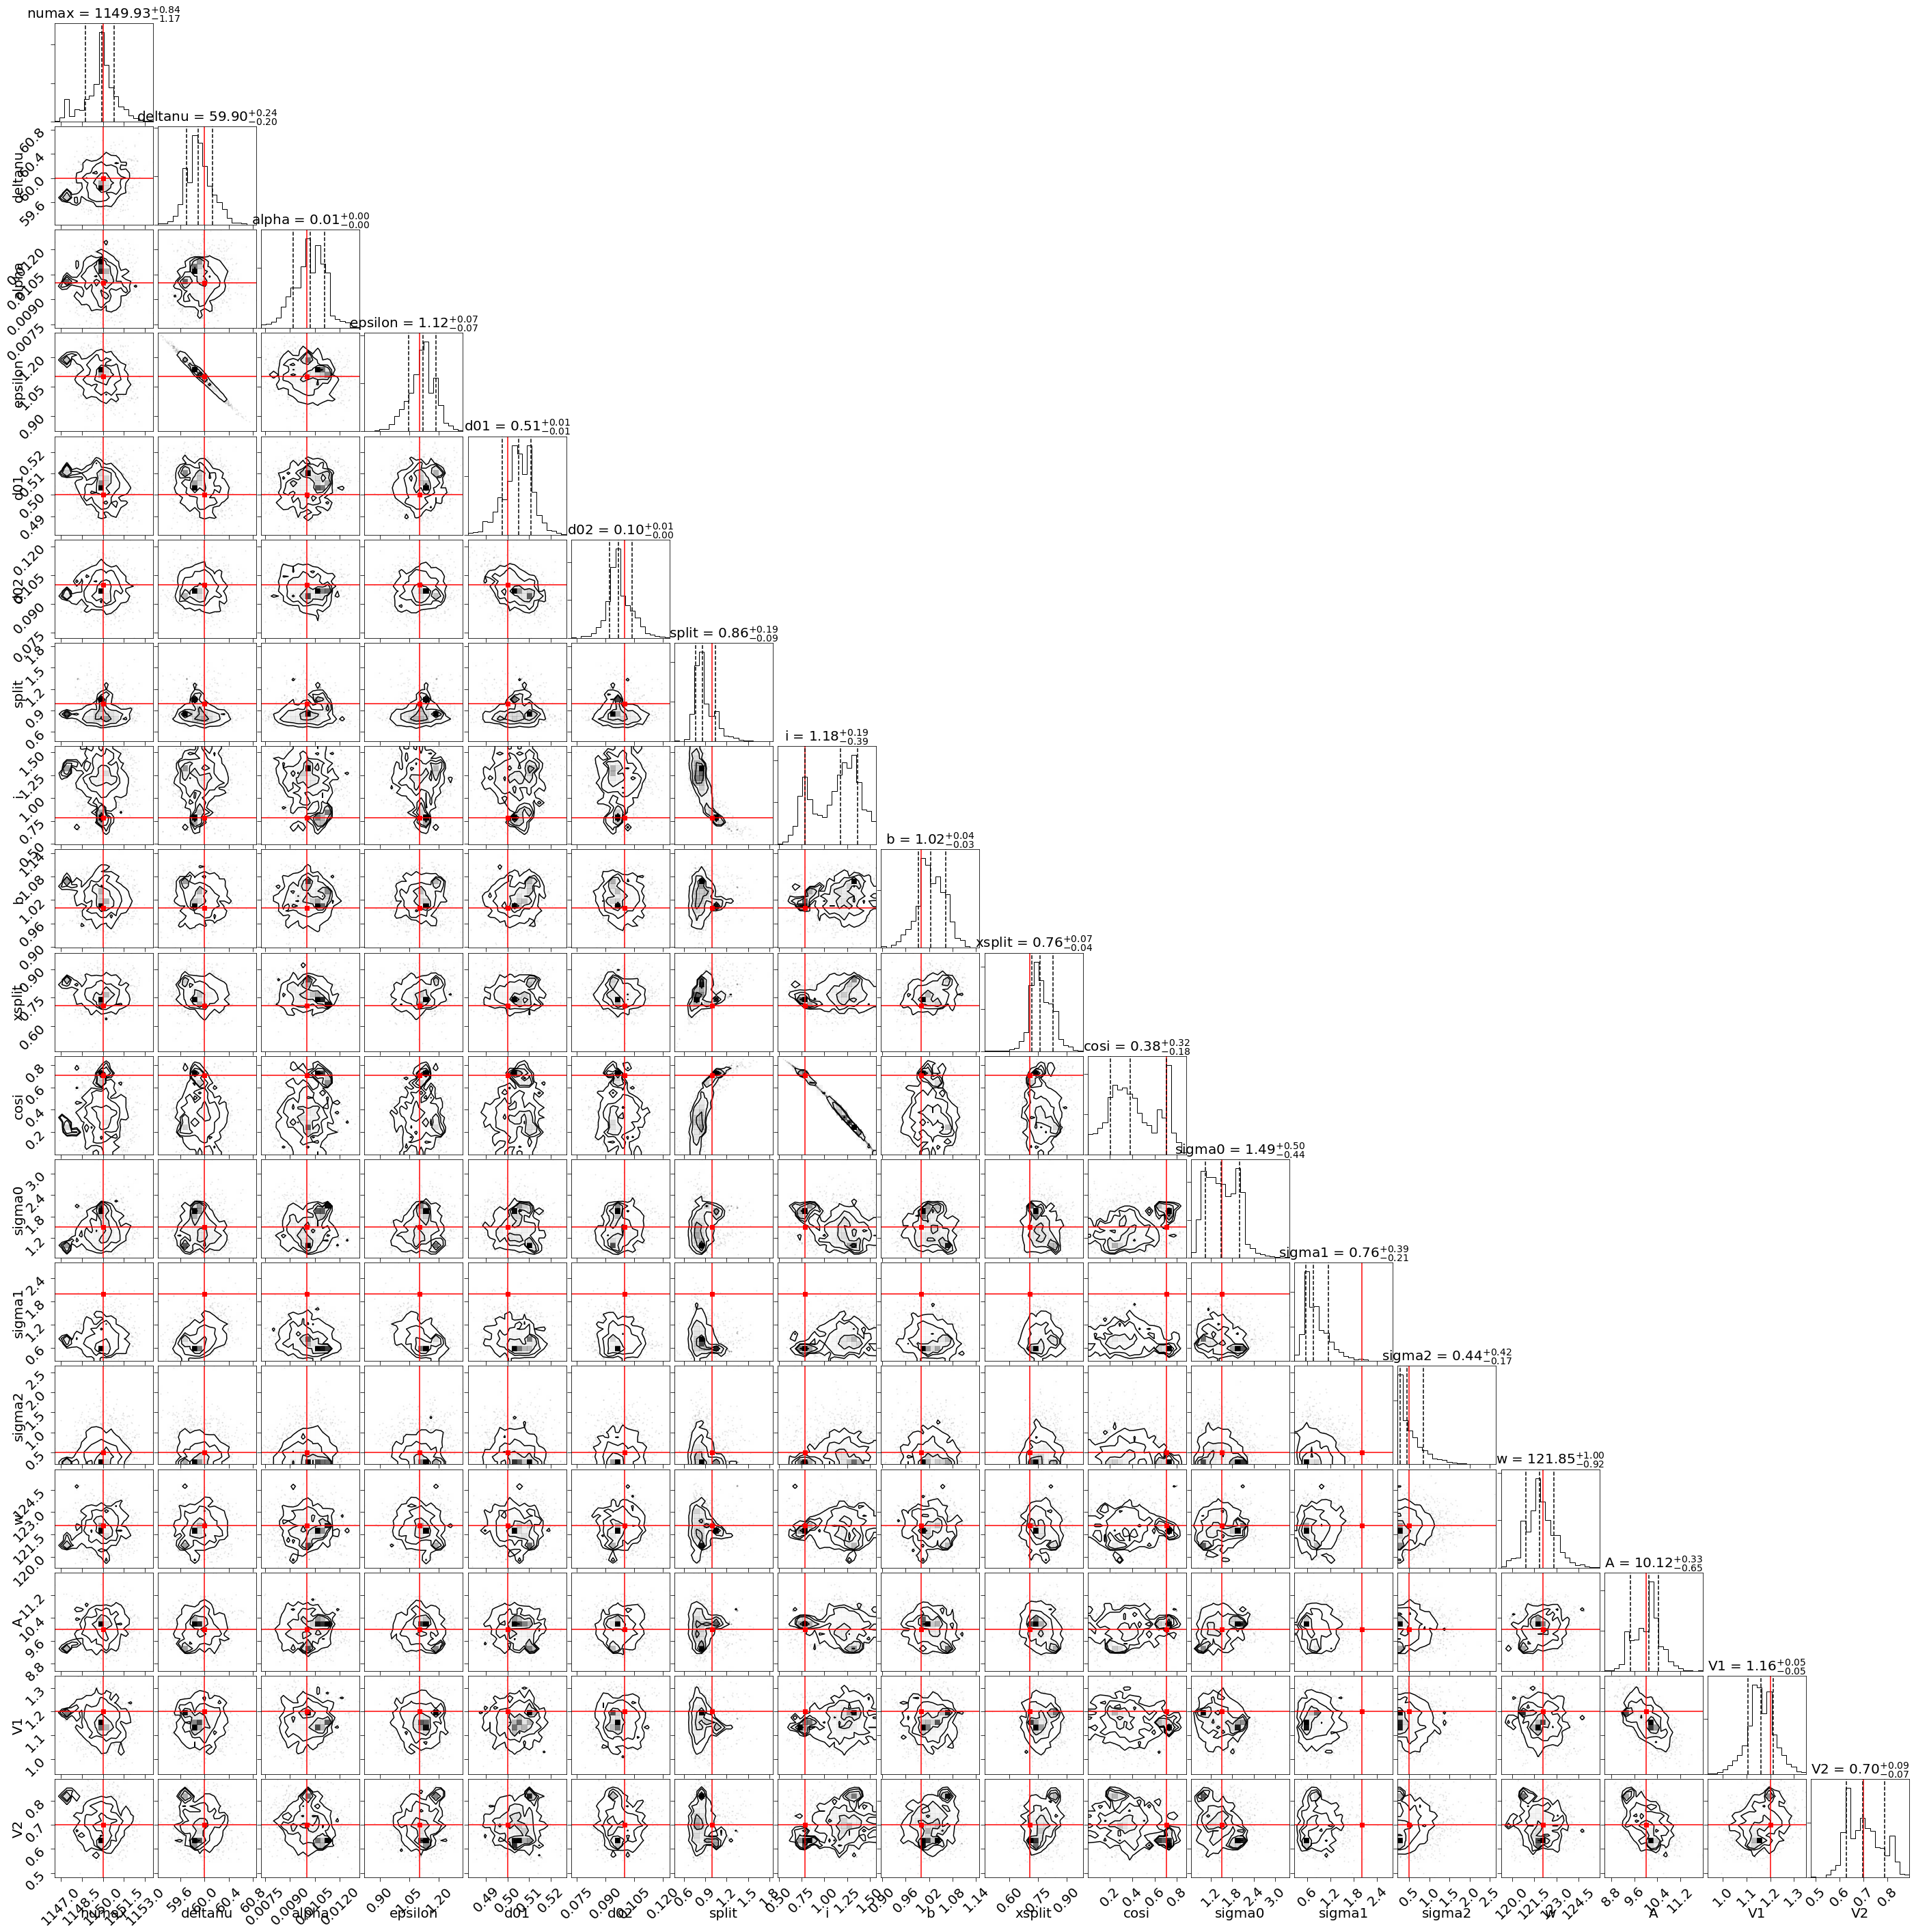

In [54]:
labels = ['numax','deltanu','alpha','epsilon','d01','d02',
          'split','i','b','xsplit','cosi','sigma0','sigma1','sigma2',
          'w','A','V1','V2']
chain = np.array([trace[label] for label in labels])
truths = [numax_, deltanu_, alpha_, epsilon_, d01_, d02_,
         init_m[9], init_m[10], init_m[11], init_m[9]*np.sin(init_m[10]), np.cos(init_m[10]),
         sigma0_, sigma1_, sigma2_, w_, A_, V1_, V2_]
corner.corner(chain.T, labels=labels, truths=truths, quantiles=[.16, .5, .84], truth_color='r',show_titles=True)
plt.show()

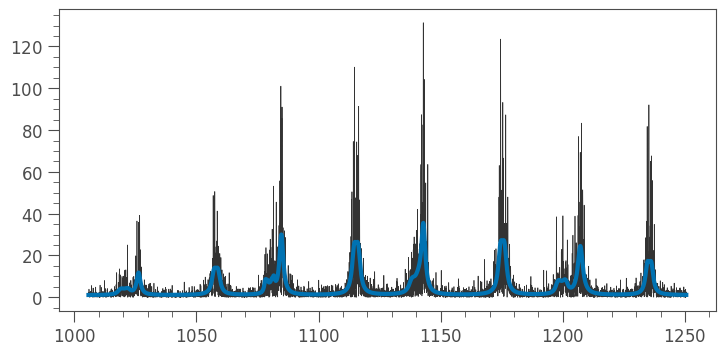

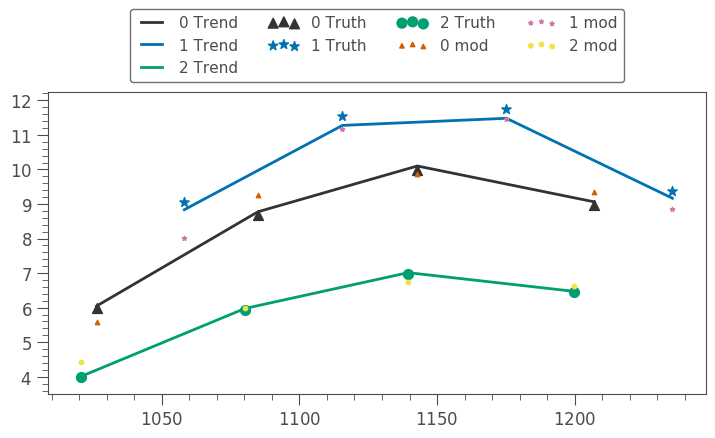

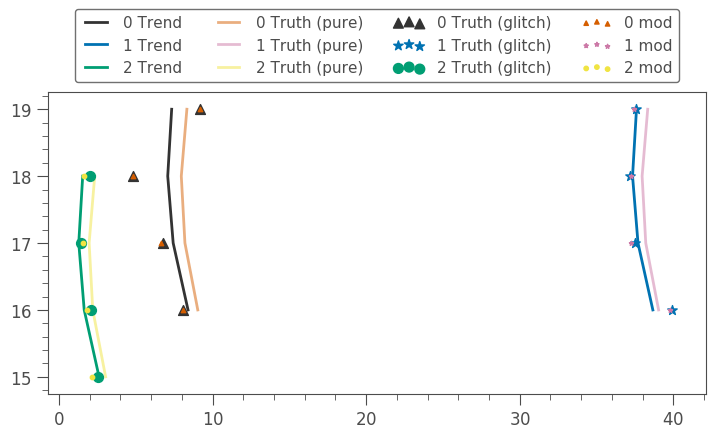

In [53]:
with plt.style.context(ms.ms):
    res_m = [np.median(trace[label], axis=0) for label in ['f0','f1','f2','g0','g1','g2',
                                                         'h0','h1','h2','split','i','b']]
    plt.plot(f, p)
    plt.plot(f, mod.model(res_m, theano=False), lw=3)
    plt.show()
    
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax', 'w', 'A', 'V1','V2']]
    resls = [np.median(trace[label],axis=0) for label in ['a0','a1','a2']]
       
    ax.plot(f0_, mod.A0(f0_, res, theano=False), label='0 Trend',lw=2, zorder=1)
    ax.plot(f1_, mod.A1(f1_, res, theano=False), label='1 Trend',lw=2, zorder=1)
    ax.plot(f2_, mod.A2(f2_, res, theano=False), label='2 Trend',lw=2, zorder=1)

    ax.scatter(f0_, amps[0], marker='^',label='0 Truth',  s=50, zorder=2)
    ax.scatter(f1_, amps[1], marker='*',label='1 Truth',  s=50, zorder=2)
    ax.scatter(f2_, amps[2], marker='o',label='2 Truth',  s=50, zorder=2)   

    ax.scatter(f0_, resls[0], marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(f1_, resls[1], marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(f2_, resls[2], marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))
    plt.show()
    
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax', 'deltanu', 'alpha', 'epsilon','d01','d02']]
    resls = [np.median(trace[label],axis=0) for label in ['f0','f1','f2']]
    stdls = [np.std(trace[label],axis=0) for label in ['f0','f1','f2']]
       
    ax.plot(mod.f0(res)%res[1], n0_, label='0 Trend',lw=2, zorder=1)
    ax.plot(mod.f1(res)%res[1], n1_, label='1 Trend',lw=2, zorder=1)
    ax.plot(mod.f2(res)%res[1], n2_, label='2 Trend',lw=2, zorder=1)

    ax.scatter(f0_%res[1], n0_, marker='^',label='0 Truth (glitch)',  s=50, zorder=2)
    ax.scatter(f1_%res[1], n1_, marker='*',label='1 Truth (glitch)',  s=50, zorder=2)
    ax.scatter(f2_%res[1], n2_, marker='o',label='2 Truth (glitch)',  s=50, zorder=2)   
    
    ax.plot(f0_true%res[1], n0_, alpha=.5, label='0 Truth (pure)',  lw=2, zorder=1)
    ax.plot(f1_true%res[1], n1_, alpha=.5, label='1 Truth (pure)',  lw=2, zorder=1)
    ax.plot(f2_true%res[1], n2_, alpha=.5, label='2 Truth (pure)',  lw=2, zorder=1)      
    
    ax.scatter(resls[0]%res[1], n0_, marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(resls[1]%res[1], n1_, marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(resls[2]%res[1], n2_, marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))    

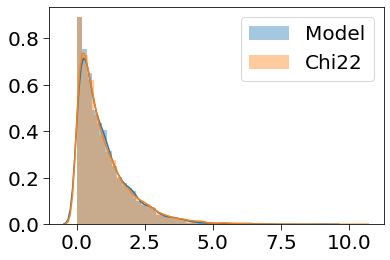

In [49]:
residual = p/mod.model(res_m, theano=False)
sns.distplot(residual, label='Model')
sns.distplot(np.random.chisquare(2, size=10000)/2, label=r'Chi22')
plt.legend()

## Let's investigate any divergences:

In [50]:
def pairplot_divergence(x, y, trace, ax=None, divergence=True, color='C3', divergence_color='C2'):
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(x, y, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace['diverging']
        ax.plot(x[divergent], y[divergent], 'o', color=divergence_color)
    return ax

def divergence_corner(trace, labels, entry=0):
    chain = np.array([trace[label] for label in labels])
    if len(chain.shape) > 2:
        chain = chain[:,:,entry]
        print('Only showing the entry [{}] for multi-parameter labels'.format(entry))
        titleadd = '[{}]'.format(entry)
    else:
        titleadd = ''
    
    K = len(chain)
    factor = 2.0           # size of one side of one panel
    lbdim = 0.5 * factor   # size of left/bottom margin
    trdim = 0.2 * factor   # size of top/right margin
    whspace = 0.05         # w/hspace size
    plotdim = factor * K + factor * (K - 1.) * whspace
    dim = lbdim + plotdim + trdim

    # Create a new figure if one wasn't provided.
    fig, axes = plt.subplots(K, K, figsize=(dim, dim))

    lb = lbdim / dim
    tr = (lbdim + plotdim) / dim
    fig.subplots_adjust(left=lb, bottom=lb, right=tr, top=tr,
                        wspace=whspace, hspace=whspace)

    hist_kwargs = dict()
    hist_kwargs["color"] = hist_kwargs.get("color", 'k')
    for i, x in enumerate(chain):
        ax = axes[i,i]
        bins_1d = int(max(1, 20.))
        n, _, _ = ax.hist(x, bins=bins_1d, histtype='step')       


        title = "{}{}".format(labels[i], titleadd)
        ax.set_title(title)    

        for j, y in enumerate(chain):
            ax = axes[i, j]

            if j > i:    
                ax.set_frame_on(False)
                ax.set_xticks([])
                ax.set_yticks([])
                continue
            elif j == i:
                ax.set_xticks([])
                ax.set_yticks([])            
                continue    

            ax = pairplot_divergence(y, x, trace, ax=ax)

            if i < K - 1:
                ax.set_xticklabels([])
            if j > 0:
                ax.set_yticklabels([])   

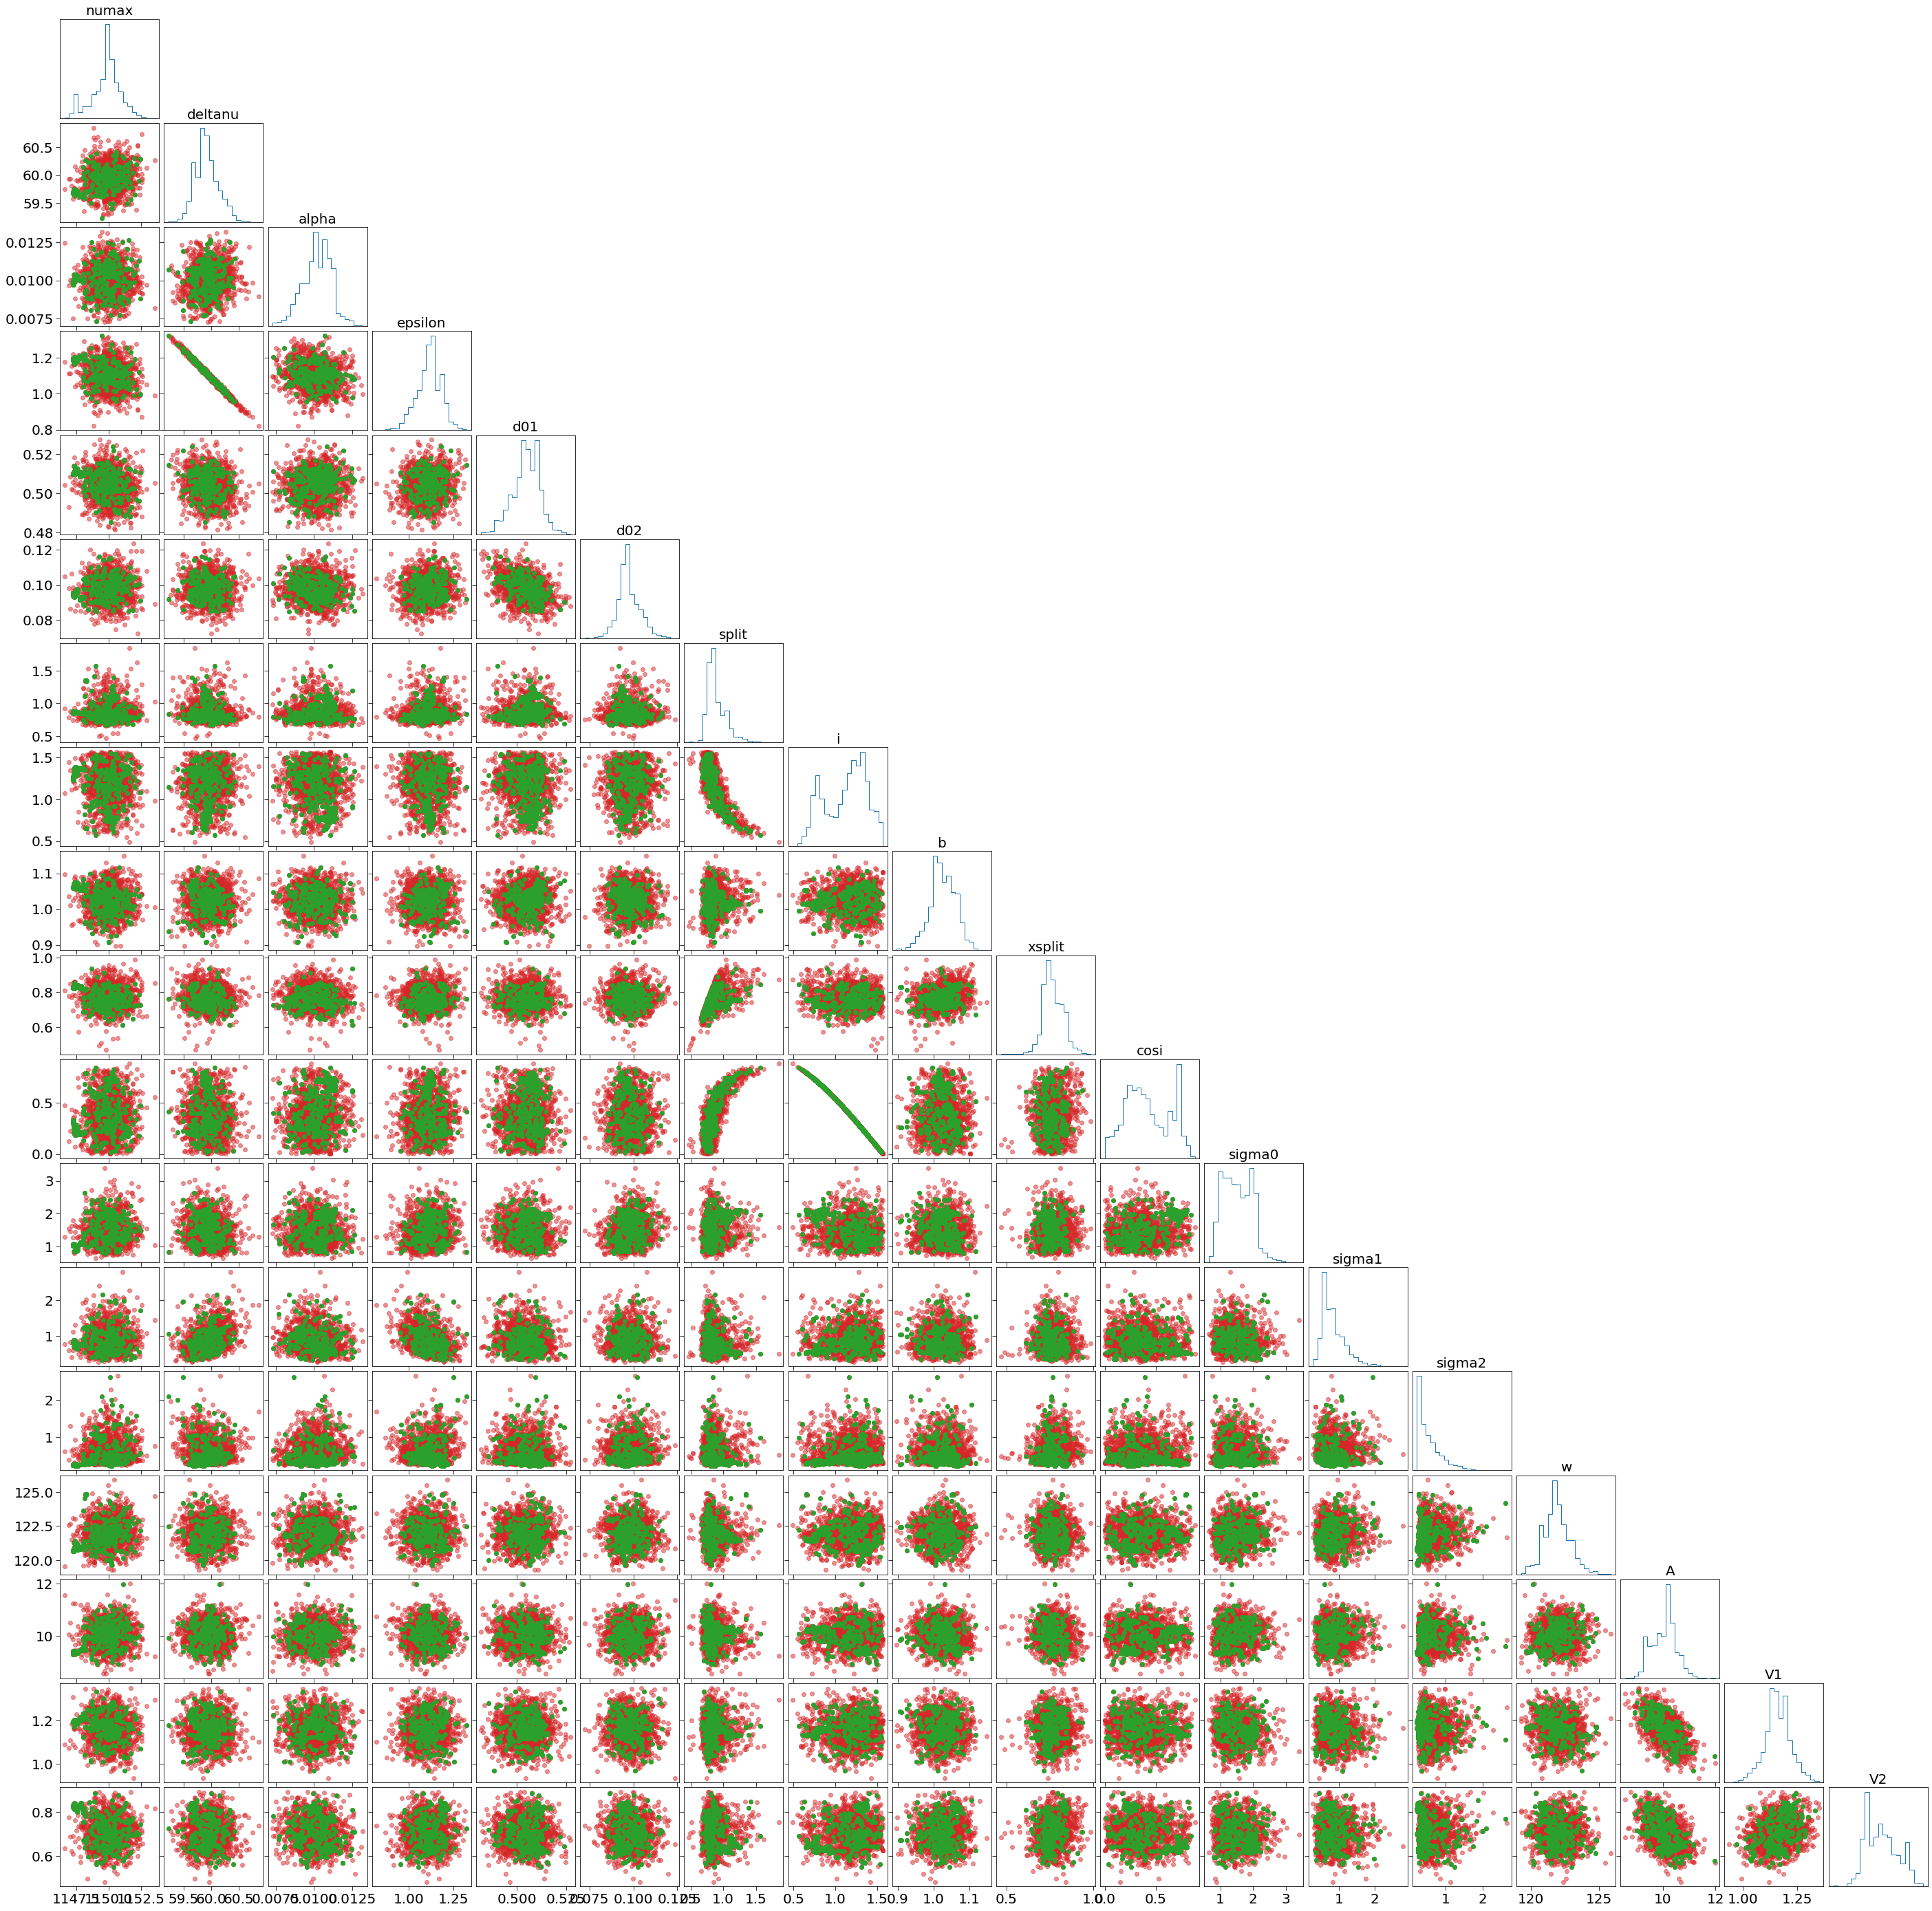

In [51]:
labels = ['numax','deltanu','alpha','epsilon','d01','d02',
          'split','i','b','xsplit','cosi','sigma0','sigma1','sigma2',
          'w','A','V1','V2']
divergence_corner(trace, labels)

In [52]:
pm.traceplot(trace)
plt.show()

/home/oliver/.local/lib/python3.7/site-packages/arviz/plots/traceplot.py:156: SyntaxWarning: max_plots is smaller than the number of variables to plot generating only max_plots traceplots
  SyntaxWarning,


KeyboardInterrupt: 